In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import re 
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from operator import itemgetter
import random
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from gensim.models import TfidfModel
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        #model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step, doc_term_matrix,dictionary):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    #x = range(start, stop, step)
    #plt.plot(x, coherence_values)
    #plt.xlabel("Number of Topics")
    #plt.ylabel("Coherence score")
    #plt.legend(("coherence_values"), loc='best')
    #plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
data = pd.read_json("5campaignNew.json")
from nltk.sentiment.vader import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])

In [ ]:
#&amp; is the html special character for &!!!!!! rimuovi!
#data.reset_index(drop=True,inplace=True)
#data.iloc[1332]["text"]

In [16]:
data["vaderScore"] = scores
#prova a togliere retweet
#data = data[data["is_retweet"] == False]
#prova a togliere numeri staccati da altre parole
#temp = []
#for idx,row in data.iterrows():
#    s = row["modded1_stemmed"]
#    c = re.sub(" \d+", " ", s)
#    temp.append(c)

#data["modded1_stemmed"] = temp

data.rename(index=str, columns={"year": "date_year"},inplace=True)

data.drop(["in_reply_to_user_id_str","is_retweet","text","modded_text","modded1","date"],axis=1,inplace=True)
data.corr()

,favorite_count,retweet_count,month,date_year,hour,week_year,labels,vaderScore
favorite_count,1.000000,0.929920,0.250773,0.509509,0.060894,0.239500,0.061381,-0.063807
retweet_count,0.929920,1.000000,0.242095,0.478042,0.066795,0.231188,0.053786,-0.087421
month,0.250773,0.242095,1.000000,-0.051940,0.071850,0.976724,0.016581,-0.043811
date_year,0.509509,0.478042,-0.051940,1.000000,0.102318,-0.055380,0.057947,-0.085754
hour,0.060894,0.066795,0.071850,0.102318,1.000000,0.072169,0.061990,-0.042753
week_year,0.239500,0.231188,0.976724,-0.055380,0.072169,1.000000,0.011615,-0.043288
labels,0.061381,0.053786,0.016581,0.057947,0.061990,0.011615,1.000000,-0.018783
vaderScore,-0.063807,-0.087421,-0.043811,-0.085754,-0.042753,-0.043288,-0.018783,1.000000


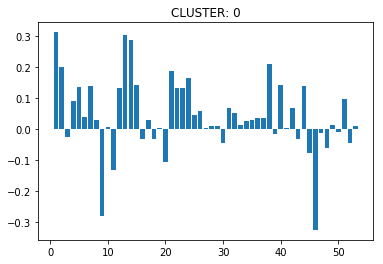

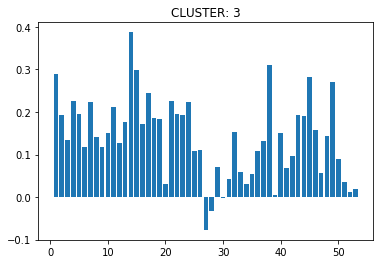

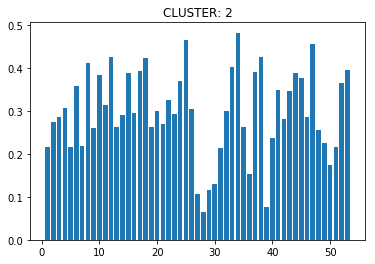

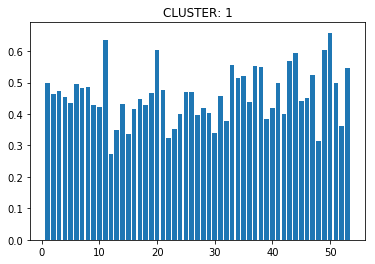

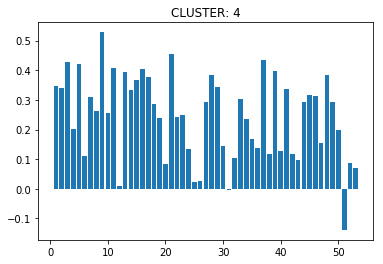

In [17]:
for cluster in data["labels"].unique():    
    time = data[data["labels"] == cluster]
    time = time.groupby(["week_year"])["vaderScore"].mean()
    plt.title("CLUSTER: " + str(cluster))
    plt.bar(time.index, time )
    plt.show()

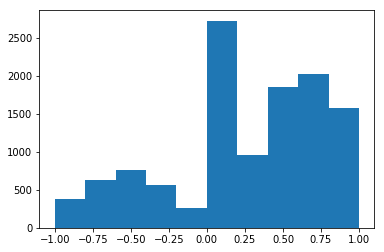

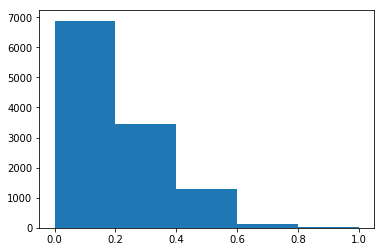

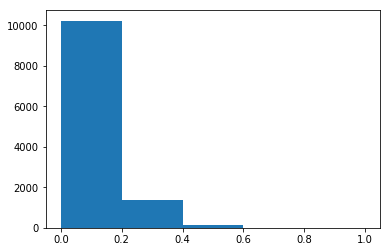

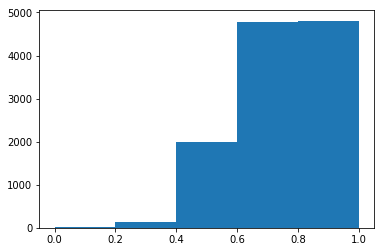

In [18]:
plt.hist(scores,bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(positive,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(negative,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

plt.hist(neut,bins=[0,0.2,0.4,0.6,0.8,1])
plt.show()

In [19]:
x1 = data[data["labels"] == 0]
print(len(x1))
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
    
stemmed_words = pd.Series(' '.join(data['modded1_stemmed']).split()).value_counts()
stemmed_words = stemmed_words[stemmed_words < 2000]
stemmed_words = stemmed_words[stemmed_words > 3]
x1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))

corpus = x1["m"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

1749


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(array([2.876e+03, 6.900e+01, 2.000e+01, 9.000e+00, 6.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 1.000e+00]),
 array([   4. ,  168.8,  333.6,  498.4,  663.2,  828. ,  992.8, 1157.6,
        1322.4, 1487.2, 1652. ]),
 <a list of 10 Patch objects>)

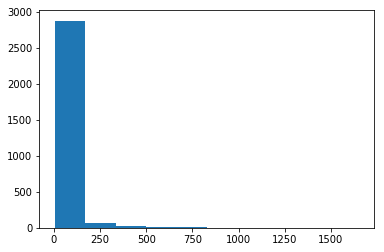

In [20]:
plt.hist(stemmed_words)

In [21]:
x1.reset_index(inplace=True,drop=True)
res = pd.concat([x1,c], axis=1)
#hour peggiora di brutto e monht alza di tanto sse!!!
res1 = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 

In [22]:
res1.columns

Index(['date_year', 'week_year', 'vaderScore', '10', '100', '1000', '100000',
       '1000000', '10am', '11',
       ...
       'york', 'yorker', 'youll', 'young', 'your', 'youtub', 'youv', 'zero',
       'zogbi', 'zuckerman'],
      dtype='object', length=2338)

# K means

res1 = res.drop(["week_year","month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
res1.columns

%%time
sse_list = list()
max_k = 20
plt.figure(figsize=(18,6))
for k in range(2,max_k):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(res1)
    sse = kmeans.inertia_
    sse_list.append(sse)
plt.plot(range(2,max_k), sse_list)
plt.show()
#1724 senza week, year; 20000 con 

#6 per il label 1 (15 cluster)
#monthe vader alzano la silhouette

#per label 2 week year peggiora sse ma aumenta silhouette
#solo vader e tfidf abbassano di un botto l'sse per label 2


#sembra che usare week year peggiori l'sse ma aumenti di molto la silhouette. Come interpretare? cosa preferire?
true_k =5
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=10)
model.fit(res1)
print(model.inertia_)
print
labels = model.labels_
res1["labels"] = labels
dataWithText["labels"] = labels
d = silhouette_score(res1, labels,metric='euclidean')
print(d)

g = res1.drop(["vaderScore"],axis=1)


for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 2:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        #meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))
        
        from gensim.corpora.dictionary import Dictionary

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        
        common_dictionary = Dictionary(corp)
        common_corpus = [common_dictionary.doc2bow(text) for text in corp]
        tfidf = TfidfModel(common_corpus)
        tfidf_corpus = tfidf[common_corpus]


        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step,tfidf_corpus,common_dictionary)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)

        lda = LdaModel(tfidf_corpus, num_topics=nTopics, id2word=common_dictionary)

        
        plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        plt.title("Sentiment score for cluster: " + str(cluster))
        plt.show()
        
        print(d1["date_year"].unique().tolist())
        print("numero di settimane in cluster", len(d1["week_year"].unique().tolist()))
        print("anni nel cluster ", len(g1["year"].unique().tolist()))
        time = d1.groupby(["week_year"])["vaderScore"].mean()
        plt.title("CLUSTER: " + str(cluster))
        plt.bar(time.index, time )
        plt.show()

        topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False,log=True)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.001:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            sns.barplot(x=weights, y=words)
            plt.show()        
        vector = lda.get_document_topics(tfidf_corpus[0])
        print(corp[0])
        print(vector)

# Hierarchical

In [23]:
from sklearn.cluster import AgglomerativeClustering
sil = []
for c in range(2,12):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=c)
    clustering.fit(res1)
    labels = clustering.labels_
    d = silhouette_score(res1, labels,metric='cosine')
    sil.append(d)
    print(c,d)

2 0.6645292359870165
3 0.7195905335392658
4 0.7650144542495365
5 0.7331701311233502
6 0.6795021083606294
7 0.6345835491809796
8 0.6344134741650023
9 0.6055052981923259
10 0.6154484512819811
11 0.586071982533095


In [24]:
res1.columns

Index(['date_year', 'week_year', 'vaderScore', '10', '100', '1000', '100000',
       '1000000', '10am', '11',
       ...
       'york', 'yorker', 'youll', 'young', 'your', 'youtub', 'youv', 'zero',
       'zogbi', 'zuckerman'],
      dtype='object', length=2338)

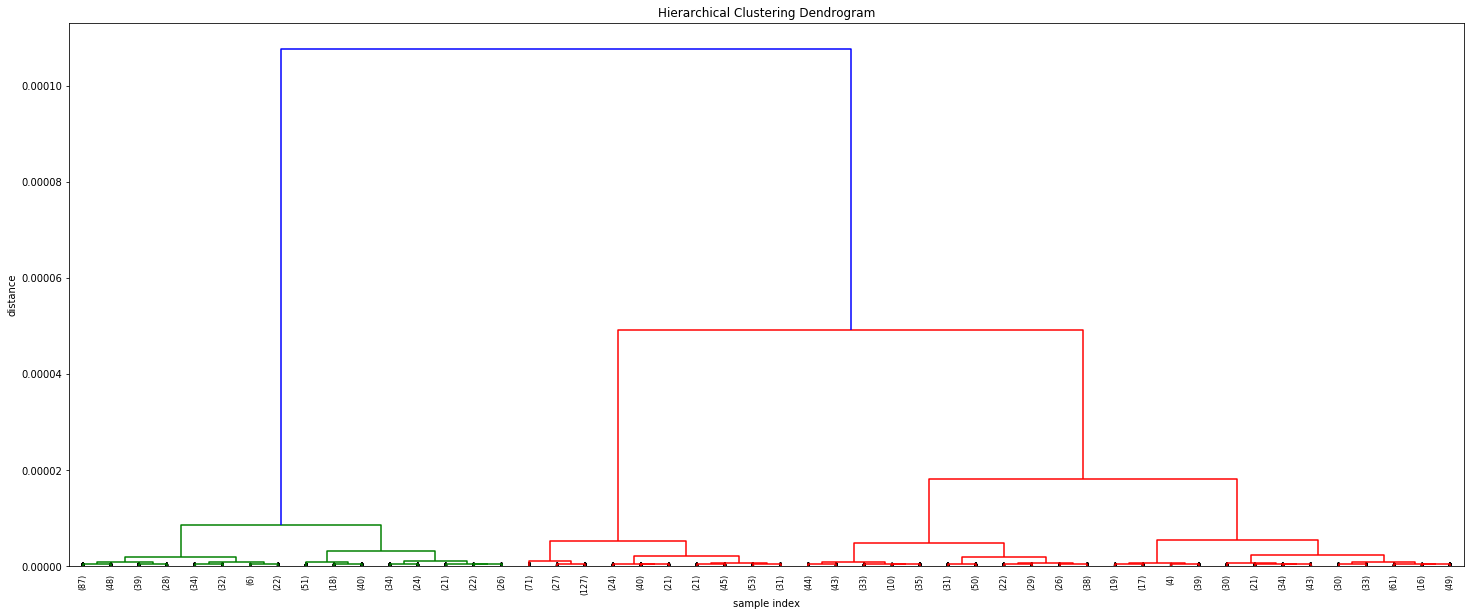

In [25]:
res1 = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 

from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(res1, 'average', "cosine")
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=50,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    show_contracted=True,
)
plt.show()


In [30]:

res1 = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 

clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=15) #50 sembra nice, 70 meh 
clustering.fit(res1)
labels = clustering.labels_
d = silhouette_score(res1, labels,metric='cosine')
print(d)



0.5505308524150925


In [31]:
res1["labels"] = labels
dataWithText["labels"] = labels
g = res1.drop(["vaderScore"],axis=1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


cluster  11  lunghezza  154
NUMBER OF TOPICS FOR CLUSTER  11  :  9
2015    104
2016     50
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[1, 2, 3]
numero di settimane in cluster 3


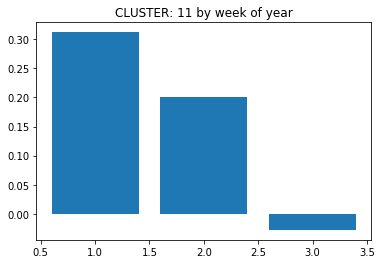

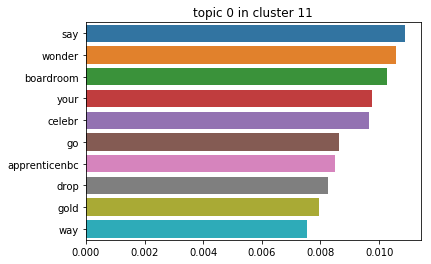

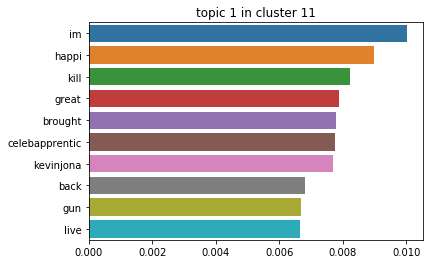

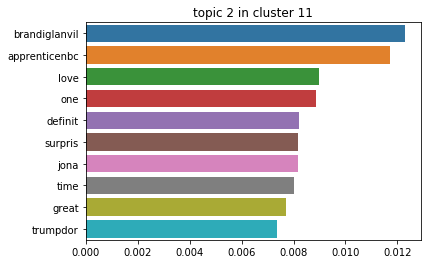

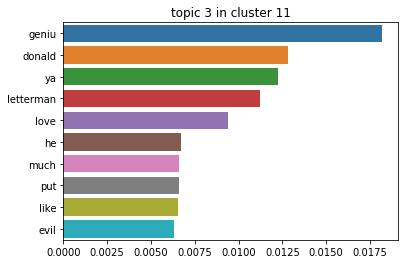

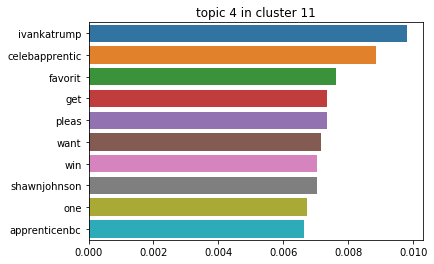

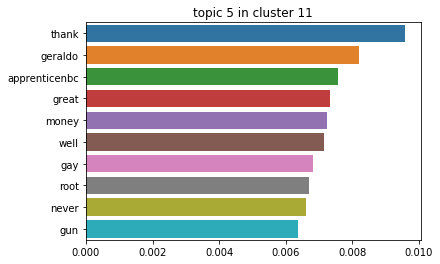

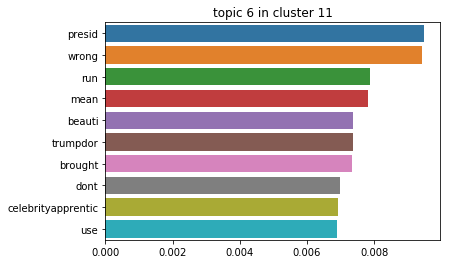

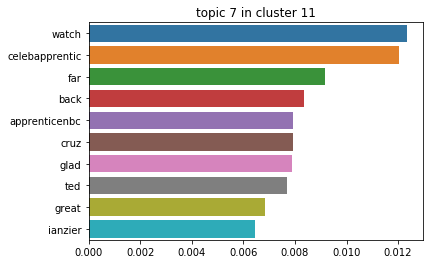

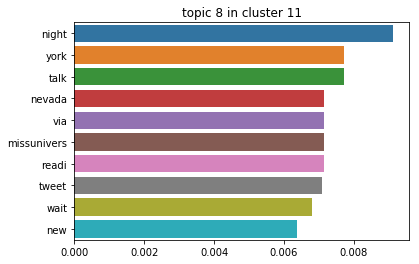

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


topics_count [26, 22, 20, 19, 18, 16, 15, 11, 7]


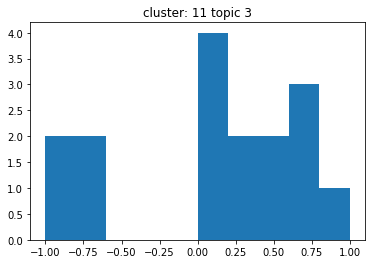

topic 3 [2015, 2016]


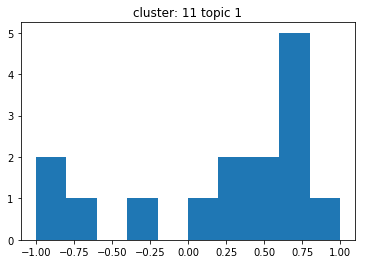

topic 1 [2015, 2016]


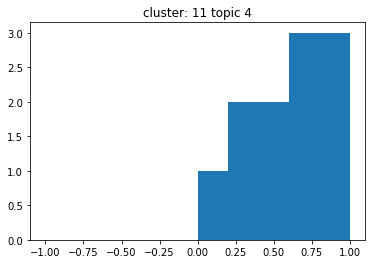

topic 4 [2015, 2016]


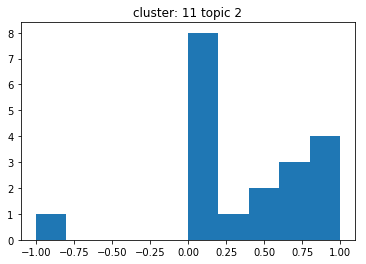

topic 2 [2015, 2016]


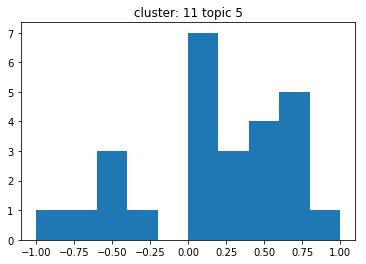

topic 5 [2015, 2016]


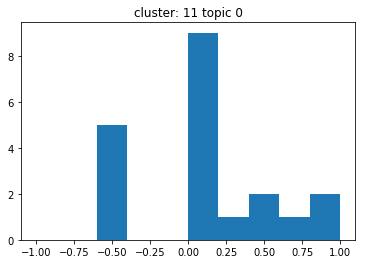

topic 0 [2015, 2016]


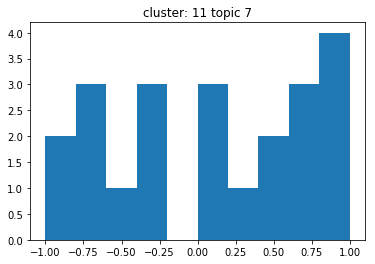

topic 7 [2015, 2016]


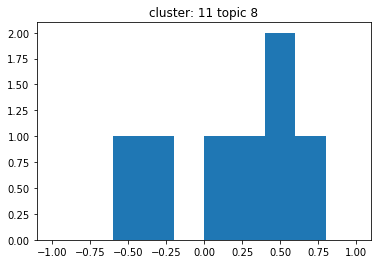

topic 8 [2015, 2016]


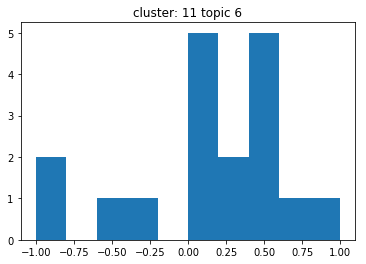

topic 6 [2015, 2016]
cluster  13  lunghezza  71
NUMBER OF TOPICS FOR CLUSTER  13  :  4
2015    41
2016    30
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[4, 5]
numero di settimane in cluster 2


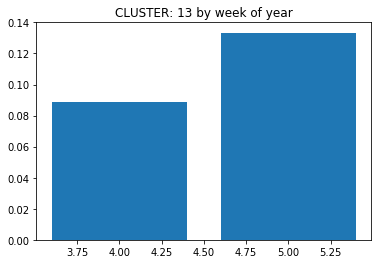

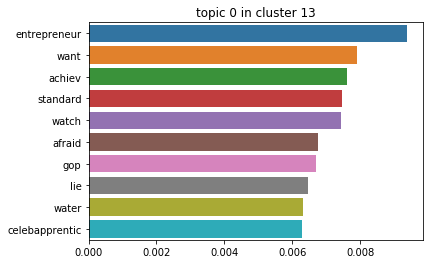

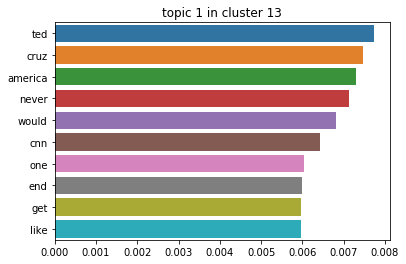

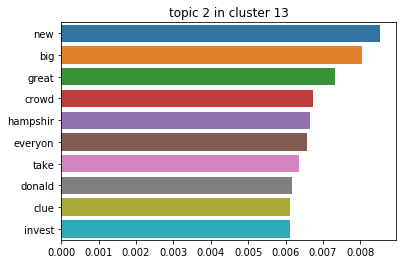

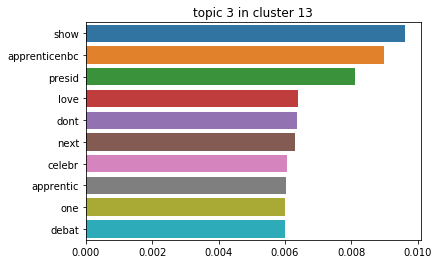

topics_count [24, 20, 16, 11]


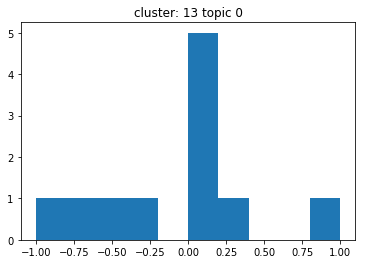

topic 0 [2015, 2016]


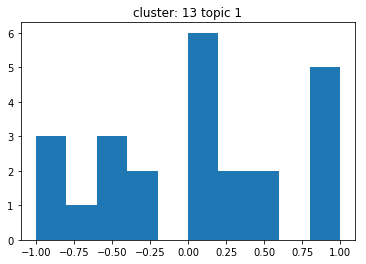

topic 1 [2015, 2016]


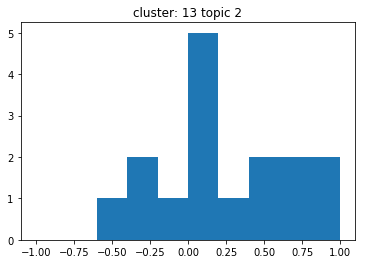

topic 2 [2015, 2016]


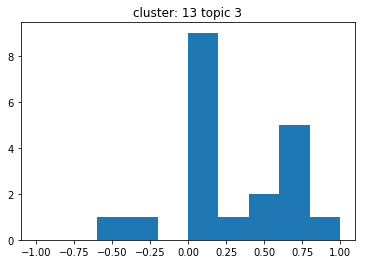

topic 3 [2015, 2016]
cluster  7  lunghezza  150
NUMBER OF TOPICS FOR CLUSTER  7  :  4
2016    77
2015    73
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[6, 7, 8, 9]
numero di settimane in cluster 4


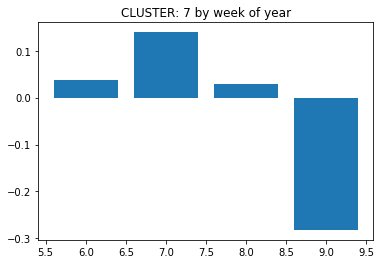

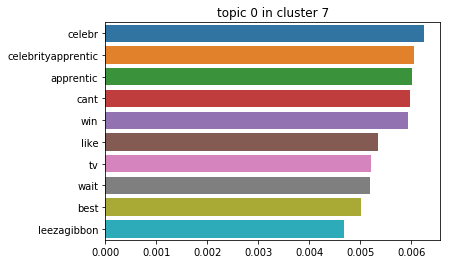

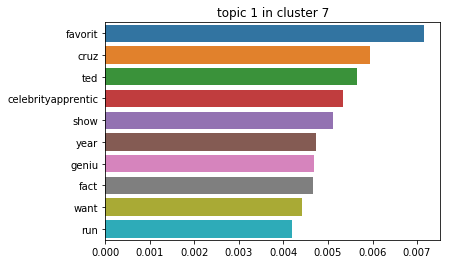

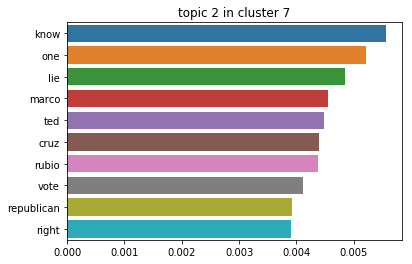

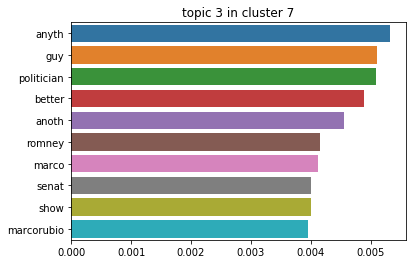

topics_count [49, 39, 32, 30]


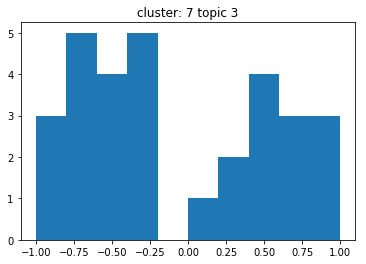

topic 3 [2015, 2016]


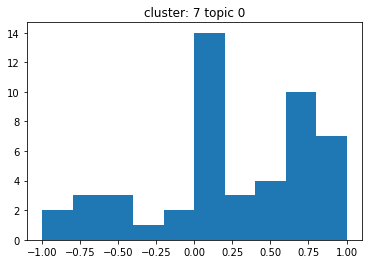

topic 0 [2015, 2016]


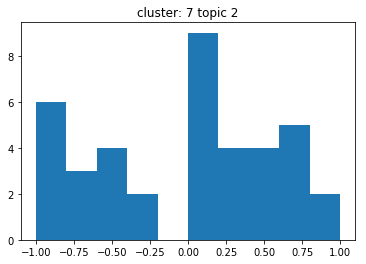

topic 2 [2015, 2016]


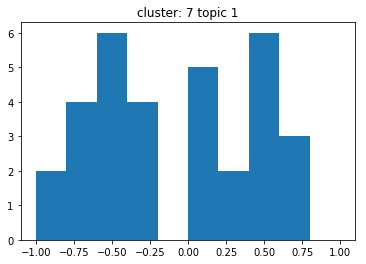

topic 1 [2015, 2016]
cluster  10  lunghezza  85
NUMBER OF TOPICS FOR CLUSTER  10  :  1
2016    55
2015    30
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[10, 11, 12]
numero di settimane in cluster 3


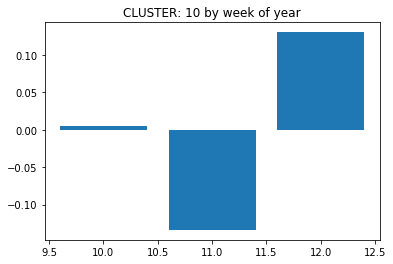

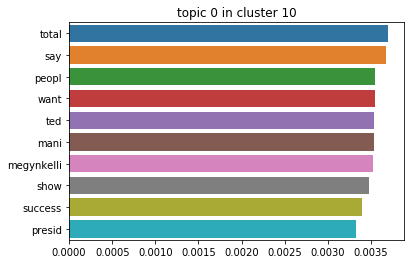

topics_count [85]


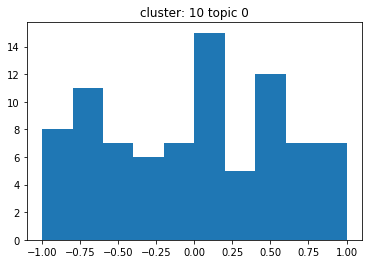

topic 0 [2015, 2016]
cluster  6  lunghezza  115
NUMBER OF TOPICS FOR CLUSTER  6  :  1
2015    90
2016    25
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[13, 14, 15, 16]
numero di settimane in cluster 4


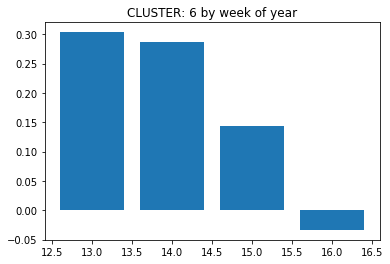

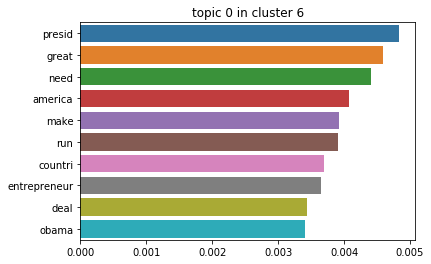

topics_count [115]


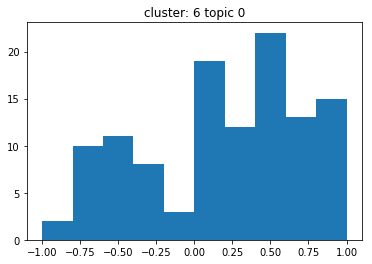

topic 0 [2015, 2016]
cluster  12  lunghezza  81
NUMBER OF TOPICS FOR CLUSTER  12  :  3
2015    56
2016    25
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[17, 18, 19]
numero di settimane in cluster 3


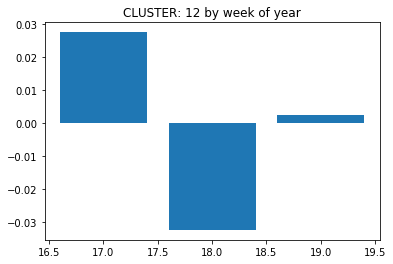

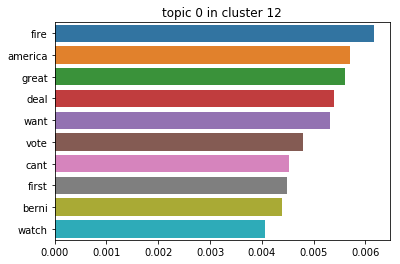

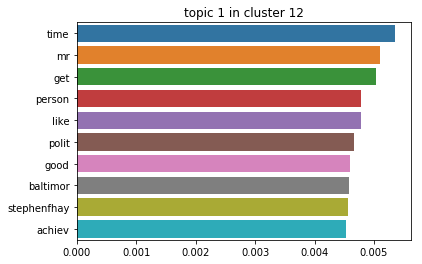

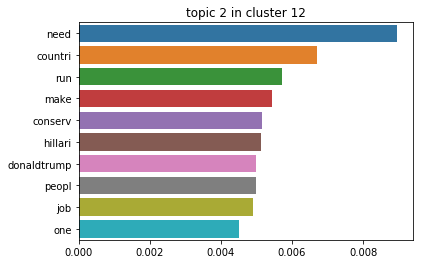

topics_count [33, 25, 23]


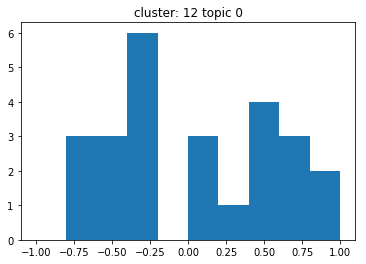

topic 0 [2015, 2016]


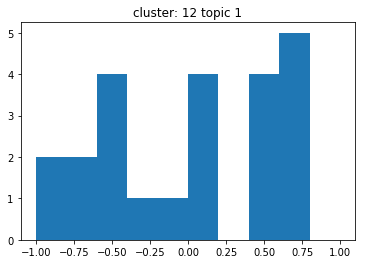

topic 1 [2015, 2016]


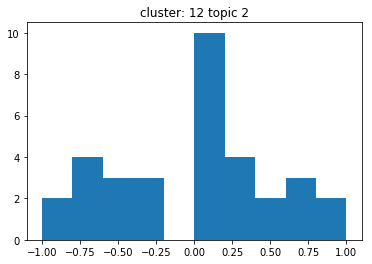

topic 2 [2015, 2016]
cluster  1  lunghezza  165
NUMBER OF TOPICS FOR CLUSTER  1  :  5
2015    103
2016     62
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[20, 21, 22, 23, 24]
numero di settimane in cluster 5


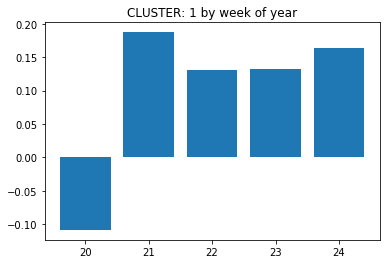

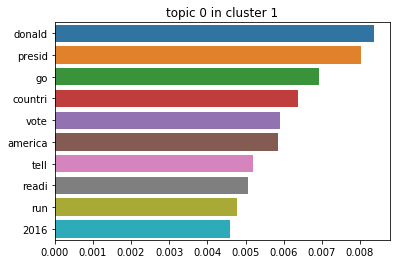

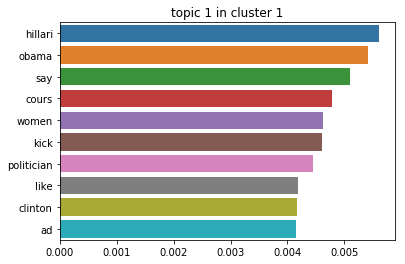

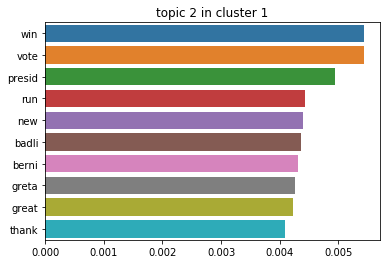

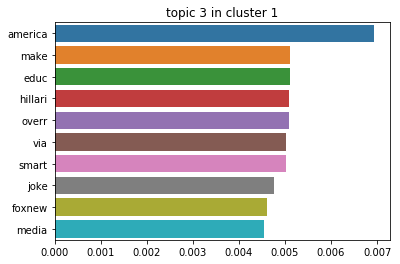

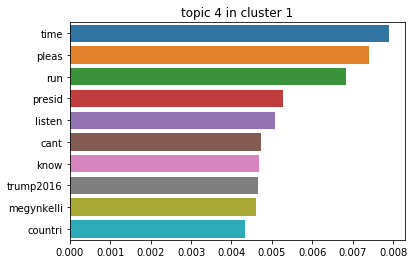

topics_count [39, 36, 34, 29, 27]


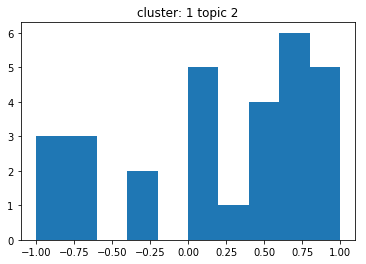

topic 2 [2015, 2016]


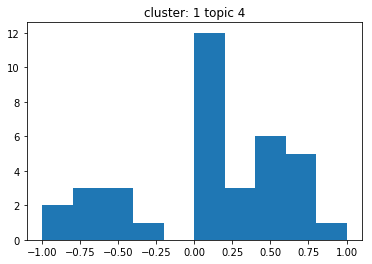

topic 4 [2015, 2016]


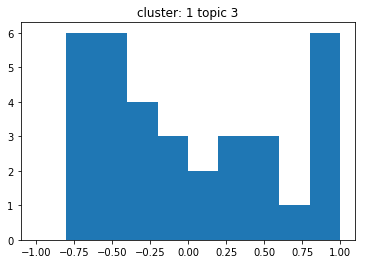

topic 3 [2015, 2016]


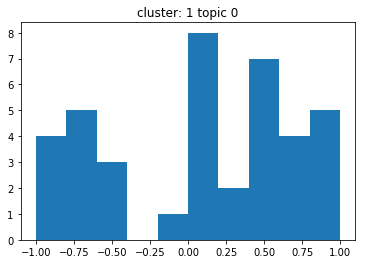

topic 0 [2015, 2016]


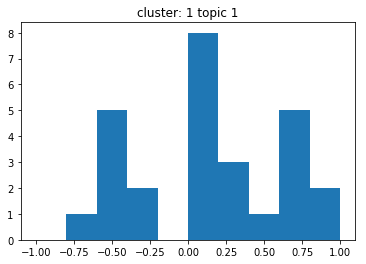

topic 1 [2015, 2016]
cluster  9  lunghezza  128
NUMBER OF TOPICS FOR CLUSTER  9  :  9
2015    81
2016    47
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[25, 26, 27, 28]
numero di settimane in cluster 4


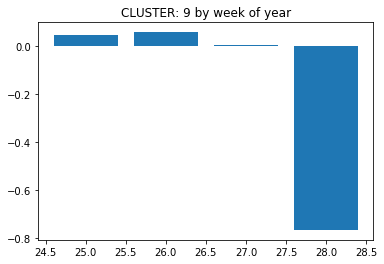

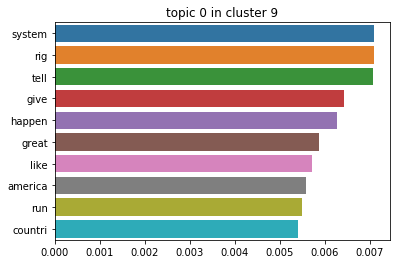

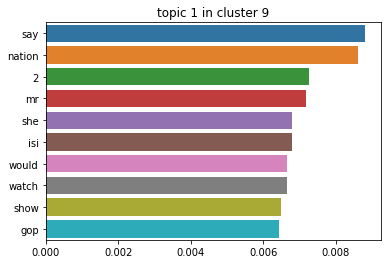

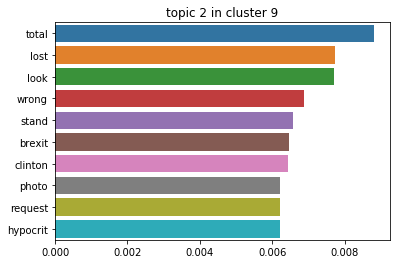

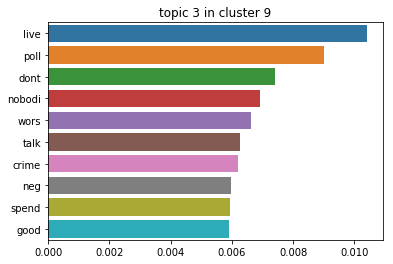

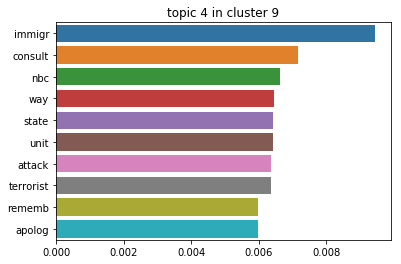

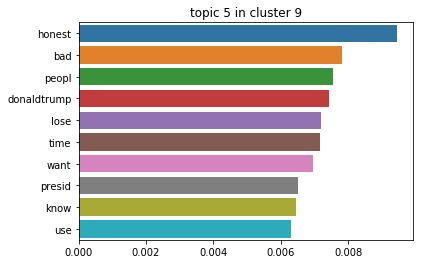

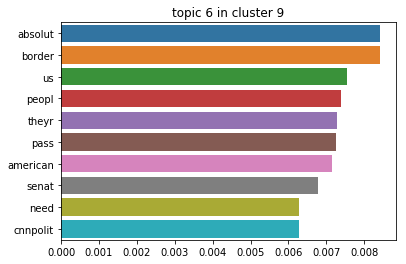

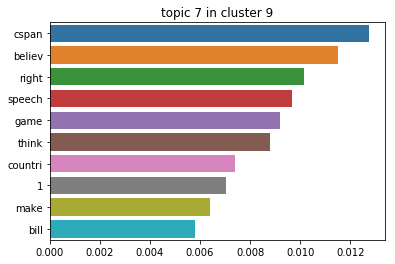

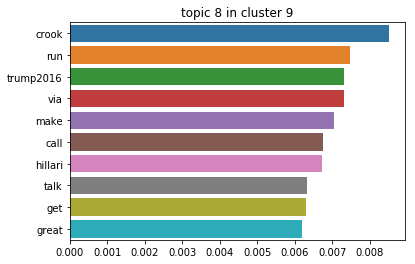

topics_count [17, 17, 17, 15, 15, 14, 13, 10, 10]


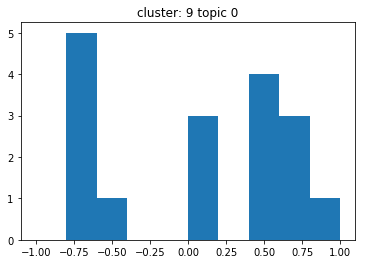

topic 0 [2015, 2016]


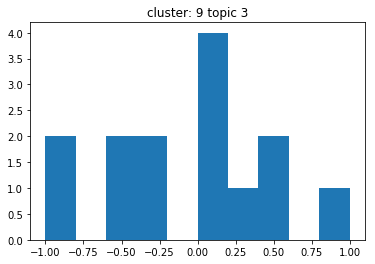

topic 3 [2015, 2016]


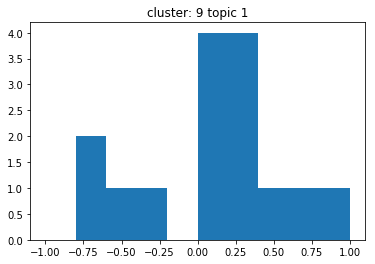

topic 1 [2015, 2016]


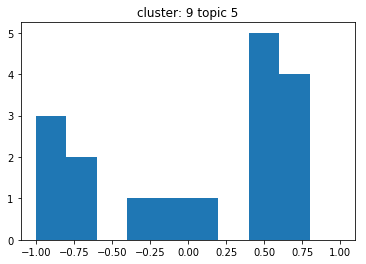

topic 5 [2015, 2016]


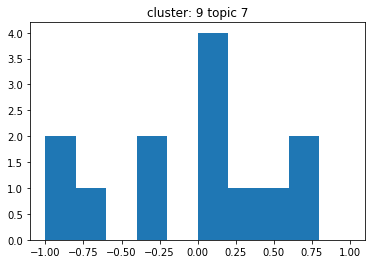

topic 7 [2015, 2016]


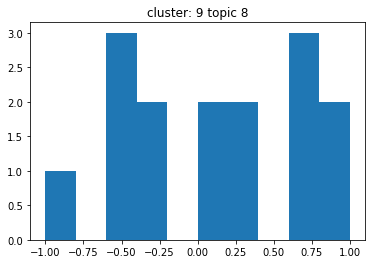

topic 8 [2015, 2016]


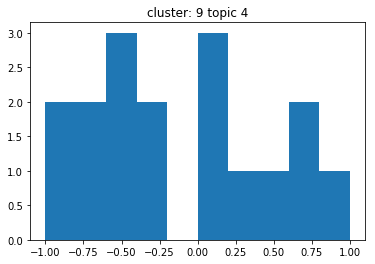

topic 4 [2015, 2016]


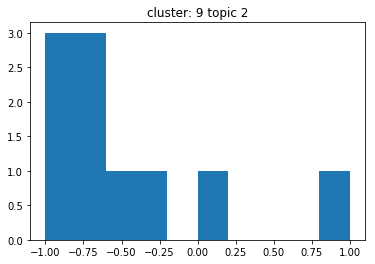

topic 2 [2015, 2016]


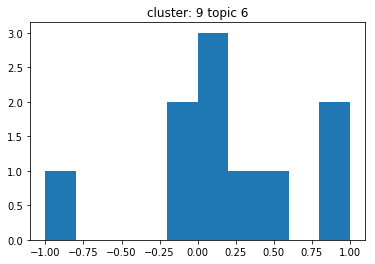

topic 6 [2015, 2016]
cluster  0  lunghezza  189
NUMBER OF TOPICS FOR CLUSTER  0  :  9
2015    115
2016     74
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[28, 29, 30, 31, 32]
numero di settimane in cluster 5


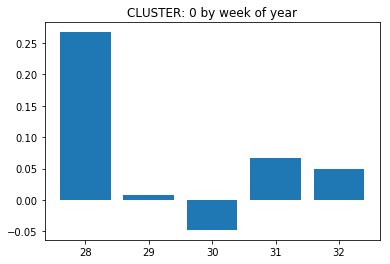

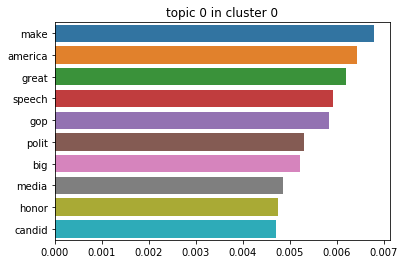

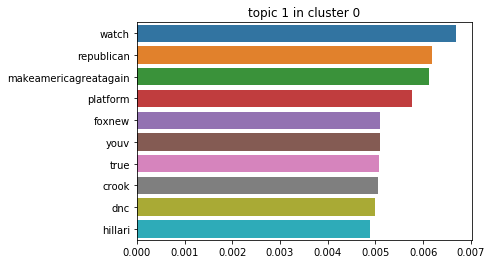

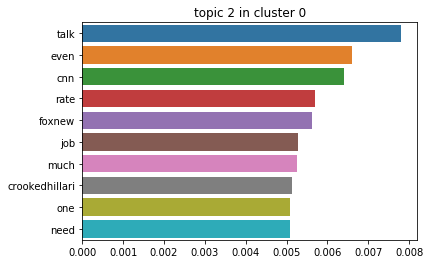

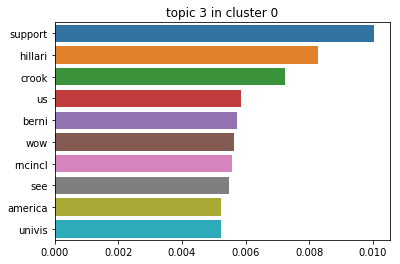

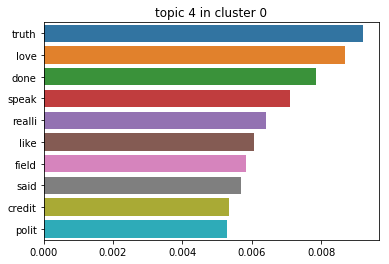

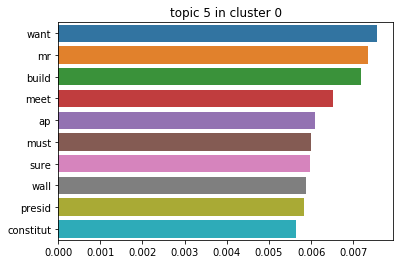

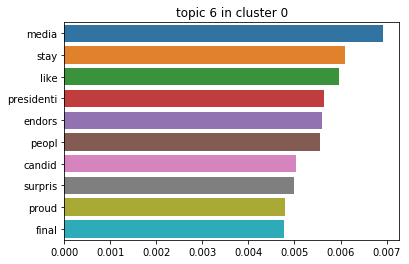

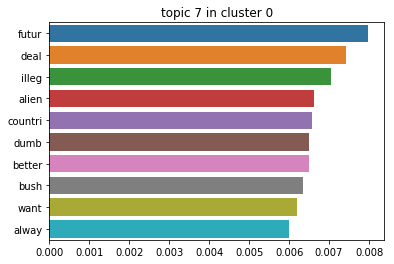

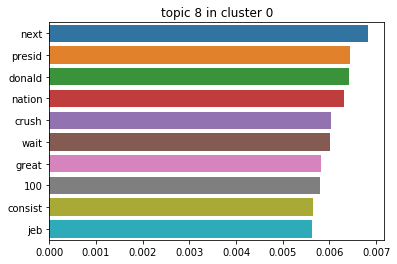

topics_count [34, 23, 23, 22, 20, 19, 19, 18, 11]


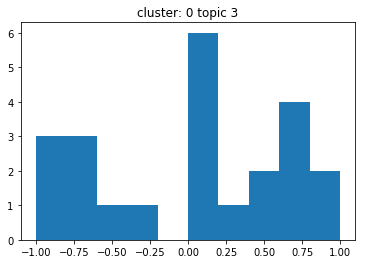

topic 3 [2015, 2016]


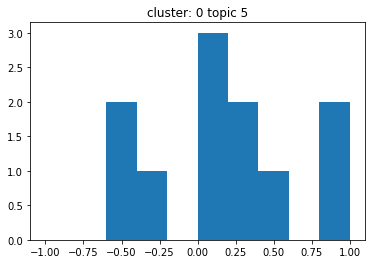

topic 5 [2015, 2016]


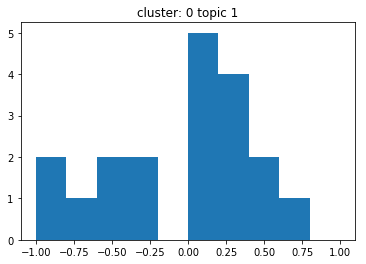

topic 1 [2015, 2016]


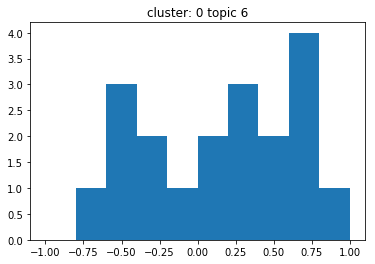

topic 6 [2015, 2016]


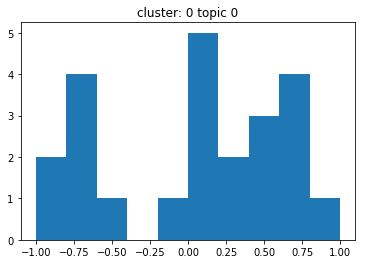

topic 0 [2015, 2016]


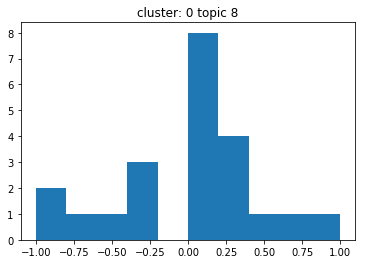

topic 8 [2015, 2016]


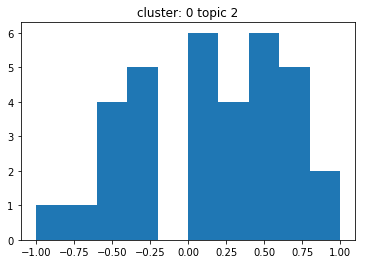

topic 2 [2015, 2016]


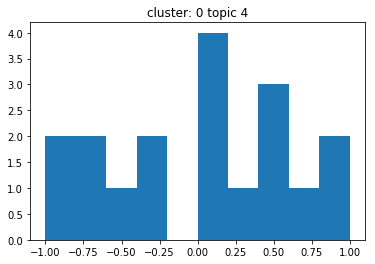

topic 4 [2015, 2016]


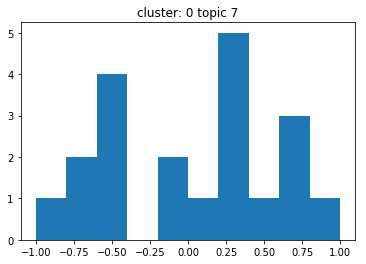

topic 7 [2015, 2016]
cluster  5  lunghezza  79
NUMBER OF TOPICS FOR CLUSTER  5  :  3
2015    44
2016    35
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[33, 34, 35, 36]
numero di settimane in cluster 4


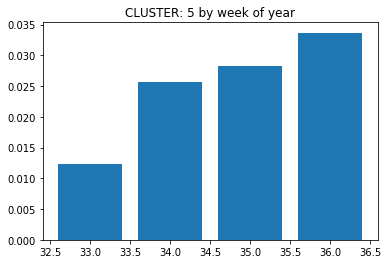

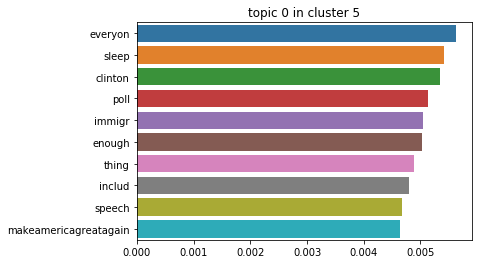

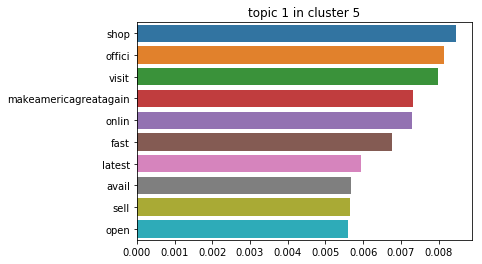

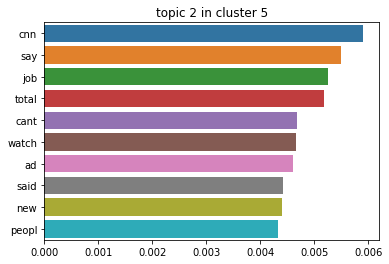

topics_count [33, 23, 23]


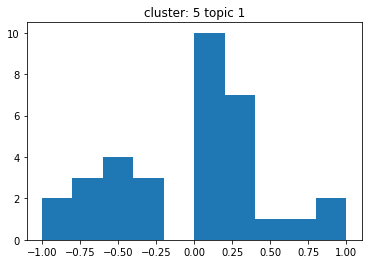

topic 1 [2015, 2016]


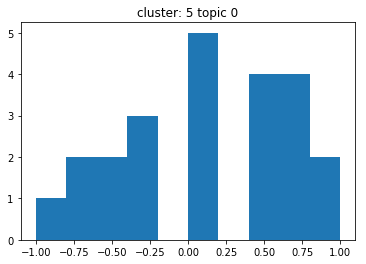

topic 0 [2015, 2016]


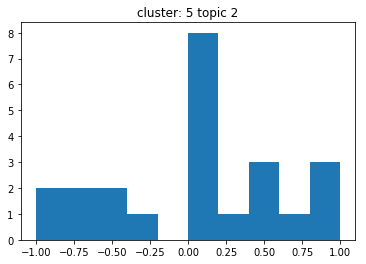

topic 2 [2015, 2016]
cluster  4  lunghezza  94
NUMBER OF TOPICS FOR CLUSTER  4  :  1
2015    51
2016    43
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[37, 38, 39, 40]
numero di settimane in cluster 4


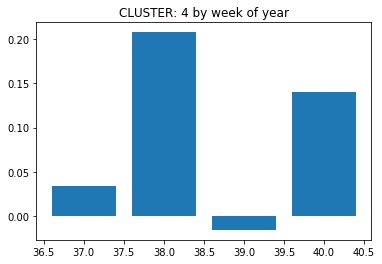

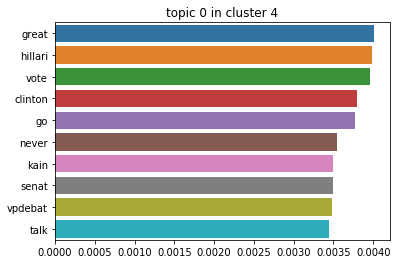

topics_count [94]


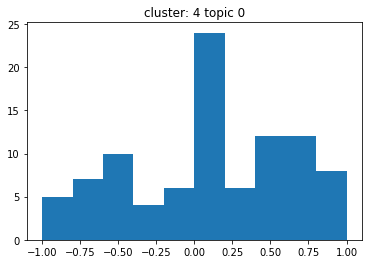

topic 0 [2015, 2016]
cluster  2  lunghezza  202
NUMBER OF TOPICS FOR CLUSTER  2  :  8
2015    133
2016     69
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[41, 42, 43, 44]
numero di settimane in cluster 4


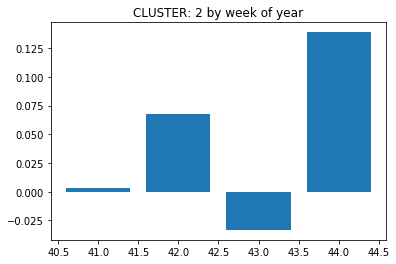

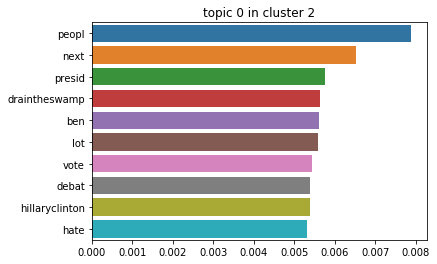

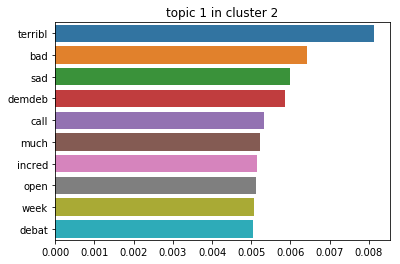

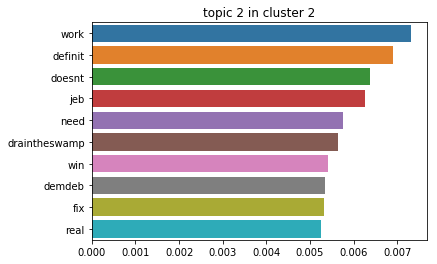

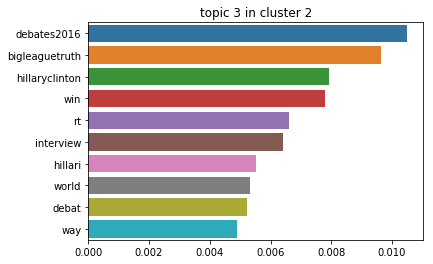

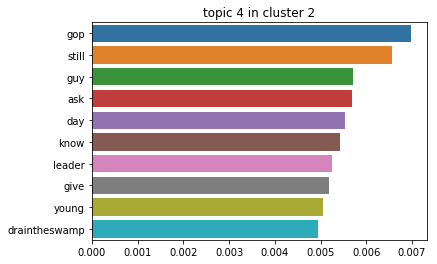

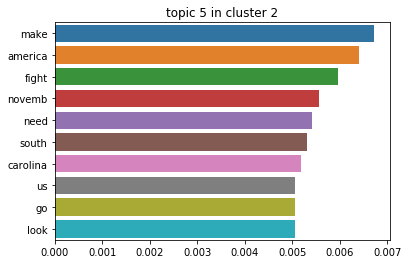

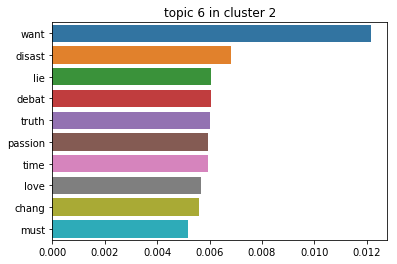

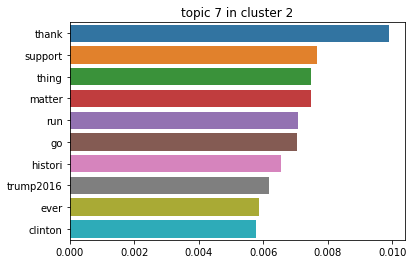

topics_count [37, 31, 26, 25, 25, 21, 20, 17]


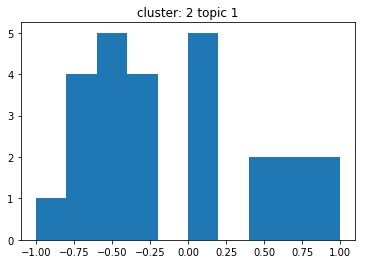

topic 1 [2015, 2016]


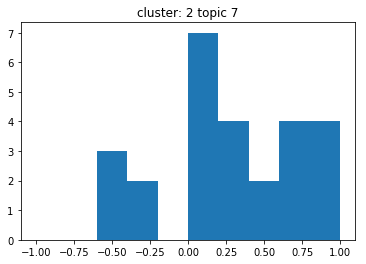

topic 7 [2015, 2016]


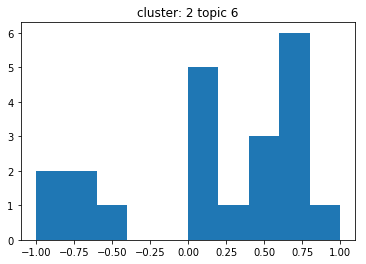

topic 6 [2015, 2016]


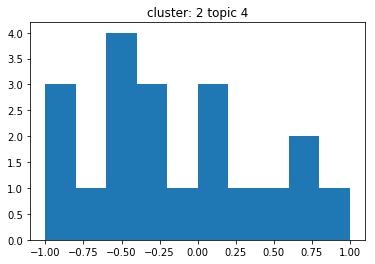

topic 4 [2015, 2016]


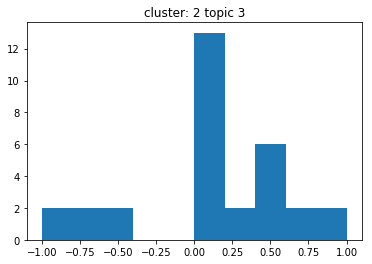

topic 3 [2015, 2016]


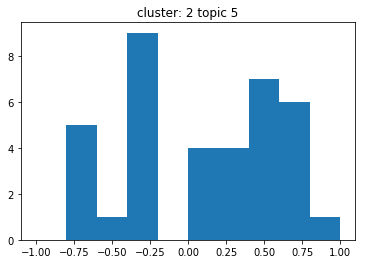

topic 5 [2015, 2016]


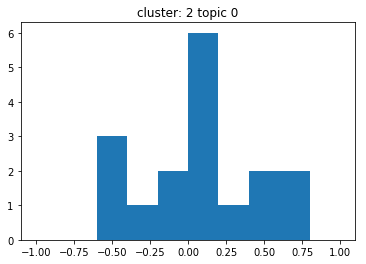

topic 0 [2015, 2016]


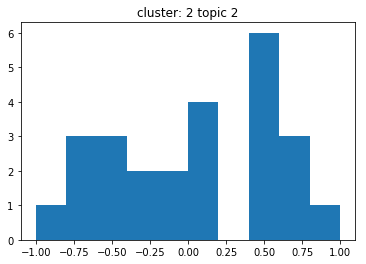

topic 2 [2015, 2016]
cluster  3  lunghezza  109
NUMBER OF TOPICS FOR CLUSTER  3  :  1
2015    90
2016    19
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[45, 46, 47, 48]
numero di settimane in cluster 4


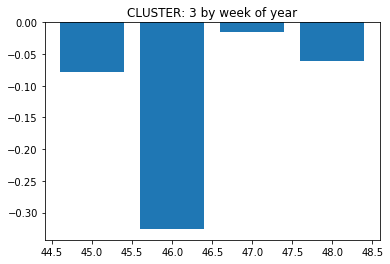

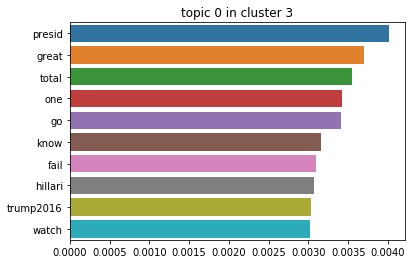

topics_count [109]


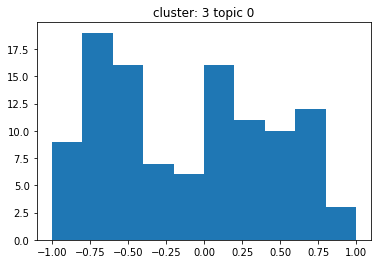

topic 0 [2015, 2016]
cluster  14  lunghezza  58
NUMBER OF TOPICS FOR CLUSTER  14  :  1
2015    47
2016    11
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[49, 50]
numero di settimane in cluster 2


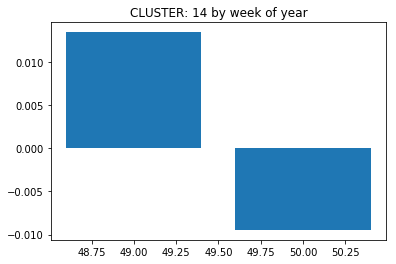

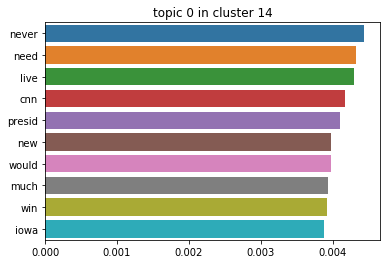

topics_count [58]


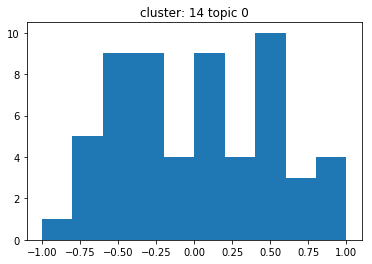

topic 0 [2015, 2016]
cluster  8  lunghezza  69
NUMBER OF TOPICS FOR CLUSTER  8  :  1
2015    52
2016    17
Name: date_year, dtype: int64
[2015, 2016]
anni nel cluster  2
[51, 52, 53]
numero di settimane in cluster 3


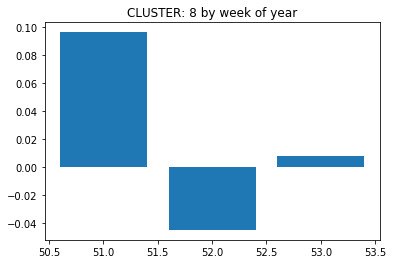

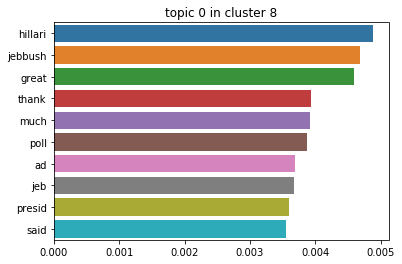

topics_count [69]


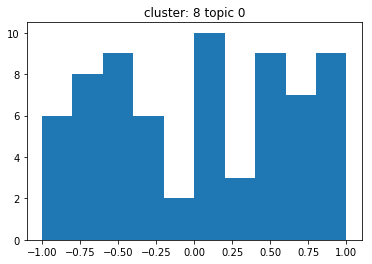

topic 0 [2015, 2016]


In [32]:

for cluster in g["labels"].unique():
    g1 = g[g["labels"] == cluster]
    d1 = dataWithText[dataWithText["labels"] == cluster]
    if len(g1) >= 2:
        meanTf = []
        for column in g1.columns:
            if column != "labels":
                m = g1[column].mean()
                meanTf.append([column,m])

        #meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
        #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")

        tokenizer = RegexpTokenizer(r'\w+')
        counted = pd.Series(' '.join(d1['m']).split()).value_counts()
        #counted = counted[5:] #5 per label 1 
        #counted = counted[counted > ]
        d1['m'] = d1['m'].apply(lambda x: " ".join(x for x in x.split() if x in counted))
        
        from gensim.corpora.dictionary import Dictionary

        corpus = d1["m"].tolist()
        #print(len(corpus))
        corp = []
        for string in corpus:
            tokens = tokenizer.tokenize(string)
            corp.append(tokens)

        
        common_dictionary = Dictionary(corp)
        common_corpus = [common_dictionary.doc2bow(text) for text in corp]
        tfidf = TfidfModel(common_corpus)
        tfidf_corpus = tfidf[common_corpus]


        start,stop,step=1,10,1
        nTopics = plot_graph(corp,start,stop,step,tfidf_corpus,common_dictionary)
        print("cluster ",cluster," lunghezza ", len(g1))
        print("NUMBER OF TOPICS FOR CLUSTER ", cluster, " : ", nTopics)

        lda = LdaModel(tfidf_corpus, num_topics=nTopics, id2word=common_dictionary)

        
        #plt.hist(d1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
        #plt.title("Sentiment score for cluster: " + str(cluster))
        #plt.show()
        print(d1["date_year"].value_counts())
        print(d1["date_year"].unique().tolist())
        print("anni nel cluster ", len(d1["date_year"].unique().tolist()))
        print(d1["week_year"].unique().tolist())
        print("numero di settimane in cluster", len(d1["week_year"].unique().tolist()))
        
        time = d1.groupby(["week_year"])["vaderScore"].mean()
        plt.title("CLUSTER: " + str(cluster) + " by week of year")
        plt.bar(time.index, time )
        plt.show()

        topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False,log=True)
        #print(g)
        for topic in topics:
            words = []
            weights = []
            for word in topic[1]:
                if abs(word[1]) > 0.001:
                    words.append(word[0])
                    #prendi valore assoluto perchè positivo/negativo non ha senso 
                    weights.append(abs(word[1]))
            labels = words
            sizes = weights
            plt.title("topic " + str(topic[0]) + " in cluster " + str(cluster))
            sns.barplot(x=weights, y=words)
            plt.show()        
        topicColumn = []
        topicList = {}
        for el in tfidf_corpus:
            vector = lda.get_document_topics(el)
            #get topic
            m = max(y for (x,y) in vector)
            ind = [x for x, y in enumerate(vector) if y[1] == m][0]
            #print(ind,m)
            if ind not in topicList:
                topicList[ind] = 1
            else: 
                topicList[ind] += 1
            topicColumn.append(ind)
        d1["topic"] = topicColumn
        #print(topicColumn)
        print("topics_count",d1["topic"].value_counts().tolist())
        
        for t in d1["topic"].unique():
            d2 = d1[d1["topic"] == t]
            plt.title("cluster: " + str(cluster) + " topic " + str(t))
            plt.hist(d2["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
            plt.show()
            print("topic "+ str(t), d2["date_year"].unique().tolist())
        
        
        